# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [1]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

In [2]:
path = '/media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [3]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media/max102

# Prepare the dataset
## 1. Get copick root

In [4]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [5]:
# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomograms(tomo_type)[0].numpy()
        target = np.zeros(tomo.shape, dtype=np.uint8)
        for pickable_object in root.pickable_objects:
            pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
            if len(pick):  
                target = segmentation_from_picks.from_picks(pick[0], 
                                                            target, 
                                                            target_objects[pickable_object.name]['radius'],# * 0.8,
                                                            target_objects[pickable_object.name]['label']
                                                            )
        write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|██████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [6]:
data_dicts = []
for run in tqdm(root.runs):
    tomogram = run.get_voxel_spacing(voxel_size).get_tomograms(tomo_type)[0].numpy()
    segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
    data_dicts.append({"image": tomogram, "label": segmentation})
    
print(np.unique(data_dicts[0]['label']))

100%|██████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.66it/s]


[0 1 3 4 5 6]


## 4. Visualize the tomogram and painted segmentation from ground-truth picks

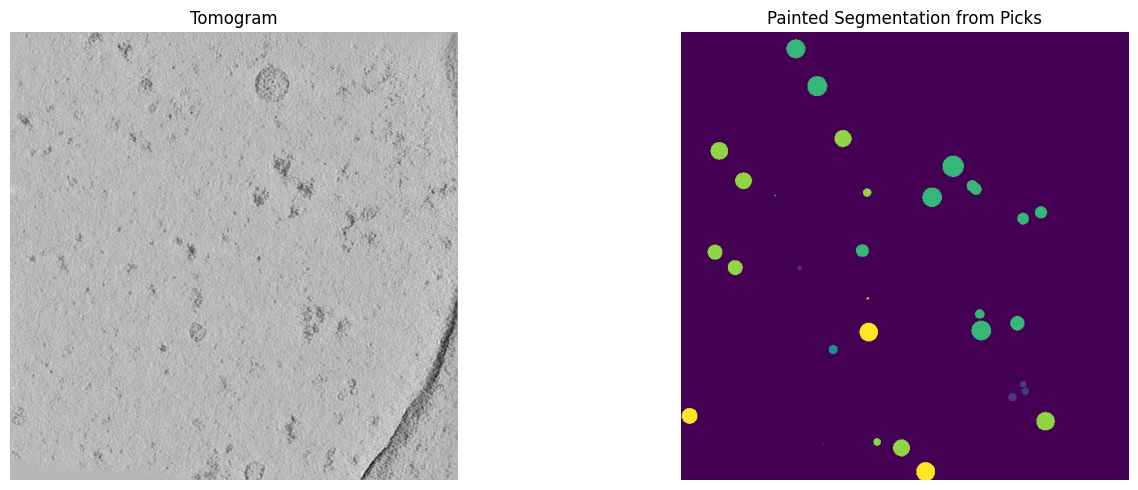

In [7]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()


## 5. Prepare dataloaders

In [8]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

train_files, val_files = data_dicts[:5], data_dicts[5:7]
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

Number of training samples: 5
Number of validation samples: 2


Loading dataset: 100%|█████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.19it/s]


## Model setup

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

cuda


In [10]:
post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=25):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    
                    
                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [11]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 50
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

----------
epoch 1/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.9611
batch 2/5, train_loss: 0.9532
batch 3/5, train_loss: 0.9496
batch 4/5, train_loss: 0.9463
batch 5/5, train_loss: 0.9474
epoch 1 average loss: 0.9515
----------
epoch 2/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.9317
batch 2/5, train_loss: 0.9299
batch 3/5, train_loss: 0.9251
batch 4/5, train_loss: 0.9128
batch 5/5, train_loss: 0.9184
epoch 2 average loss: 0.9236


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 2 current mean recall per class: 0.002689, 0, 0.002423, 0.3405, 0.01526, 0.02516, 0
best mean recall: 0.0552 at epoch: 2
----------
epoch 3/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.9054
batch 2/5, train_loss: 0.8959
batch 3/5, train_loss: 0.9019
batch 4/5, train_loss: 0.9042
batch 5/5, train_loss: 0.9071
epoch 3 average loss: 0.9029
----------
epoch 4/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8908
batch 2/5, train_loss: 0.8759
batch 3/5, train_loss: 0.8881
batch 4/5, train_loss: 0.8864
batch 5/5, train_loss: 0.8791
epoch 4 average loss: 0.8841


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 4 current mean recall per class: 0.007178, 0, 0.01105, 0.2749, 0.02761, 0.01158, 0
best mean recall: 0.0552 at epoch: 2
----------
epoch 5/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8887
batch 2/5, train_loss: 0.8758
batch 3/5, train_loss: 0.8738
batch 4/5, train_loss: 0.8840
batch 5/5, train_loss: 0.8551
epoch 5 average loss: 0.8755
----------
epoch 6/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8682
batch 2/5, train_loss: 0.8589
batch 3/5, train_loss: 0.8552
batch 4/5, train_loss: 0.8531
batch 5/5, train_loss: 0.8597
epoch 6 average loss: 0.8590


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 6 current mean recall per class: 0.04902, 0, 0.04751, 0.5388, 0.06063, 0.04114, 0
best mean recall: 0.1053 at epoch: 6
----------
epoch 7/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8414
batch 2/5, train_loss: 0.8527
batch 3/5, train_loss: 0.8481
batch 4/5, train_loss: 0.8596
batch 5/5, train_loss: 0.8481
epoch 7 average loss: 0.8500
----------
epoch 8/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8359
batch 2/5, train_loss: 0.8476
batch 3/5, train_loss: 0.8507
batch 4/5, train_loss: 0.8570
batch 5/5, train_loss: 0.8328
epoch 8 average loss: 0.8448


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 8 current mean recall per class: 0.03665, 0, 0.01006, 0.4216, 0.03748, 0.02253, 0
best mean recall: 0.1053 at epoch: 6
----------
epoch 9/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8542
batch 2/5, train_loss: 0.8352
batch 3/5, train_loss: 0.8441
batch 4/5, train_loss: 0.8428
batch 5/5, train_loss: 0.8418
epoch 9 average loss: 0.8436
----------
epoch 10/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8545
batch 2/5, train_loss: 0.8503
batch 3/5, train_loss: 0.8419
batch 4/5, train_loss: 0.8392
batch 5/5, train_loss: 0.8507
epoch 10 average loss: 0.8473


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 10 current mean recall per class: 0.03368, 0, 0.0158, 0.4552, 0.04303, 0.05495, 0
best mean recall: 0.1053 at epoch: 6
----------
epoch 11/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8308
batch 2/5, train_loss: 0.8433
batch 3/5, train_loss: 0.8365
batch 4/5, train_loss: 0.8173
batch 5/5, train_loss: 0.8530
epoch 11 average loss: 0.8362
----------
epoch 12/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8344
batch 2/5, train_loss: 0.8163
batch 3/5, train_loss: 0.8299
batch 4/5, train_loss: 0.8311
batch 5/5, train_loss: 0.8283
epoch 12 average loss: 0.8280


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 12 current mean recall per class: 0.05397, 0, 0.04121, 0.5267, 0.1071, 0.1803, 0
best mean recall: 0.1299 at epoch: 12
----------
epoch 13/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8167
batch 2/5, train_loss: 0.8359
batch 3/5, train_loss: 0.8217
batch 4/5, train_loss: 0.8312
batch 5/5, train_loss: 0.8148
epoch 13 average loss: 0.8241
----------
epoch 14/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8217
batch 2/5, train_loss: 0.8255
batch 3/5, train_loss: 0.8190
batch 4/5, train_loss: 0.8223
batch 5/5, train_loss: 0.8224
epoch 14 average loss: 0.8222


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 14 current mean recall per class: 0.05635, 0, 0.0456, 0.5199, 0.1124, 0.1514, 0
best mean recall: 0.1299 at epoch: 12
----------
epoch 15/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8370
batch 2/5, train_loss: 0.8215
batch 3/5, train_loss: 0.8226
batch 4/5, train_loss: 0.8113
batch 5/5, train_loss: 0.8183
epoch 15 average loss: 0.8221
----------
epoch 16/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8393
batch 2/5, train_loss: 0.8198
batch 3/5, train_loss: 0.8278
batch 4/5, train_loss: 0.8217
batch 5/5, train_loss: 0.8198
epoch 16 average loss: 0.8257


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 16 current mean recall per class: 0.0924, 0, 0.0334, 0.4613, 0.09978, 0.3542, 0
best mean recall: 0.1487 at epoch: 16
----------
epoch 17/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8140
batch 2/5, train_loss: 0.8201
batch 3/5, train_loss: 0.8095
batch 4/5, train_loss: 0.8198
batch 5/5, train_loss: 0.8133
epoch 17 average loss: 0.8153
----------
epoch 18/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8305
batch 2/5, train_loss: 0.8074
batch 3/5, train_loss: 0.8181
batch 4/5, train_loss: 0.8194
batch 5/5, train_loss: 0.7962
epoch 18 average loss: 0.8143


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 18 current mean recall per class: 0.05316, 0, 0.04933, 0.5468, 0.1294, 0.1711, 0
best mean recall: 0.1487 at epoch: 16
----------
epoch 19/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8020
batch 2/5, train_loss: 0.8094
batch 3/5, train_loss: 0.8245
batch 4/5, train_loss: 0.7891
batch 5/5, train_loss: 0.8286
epoch 19 average loss: 0.8107
----------
epoch 20/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8225
batch 2/5, train_loss: 0.7953
batch 3/5, train_loss: 0.8271
batch 4/5, train_loss: 0.8082
batch 5/5, train_loss: 0.8084
epoch 20 average loss: 0.8123


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 20 current mean recall per class: 0.0632, 0, 0.05542, 0.4979, 0.1392, 0.4195, 0
best mean recall: 0.1679 at epoch: 20
----------
epoch 21/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8034
batch 2/5, train_loss: 0.8076
batch 3/5, train_loss: 0.8029
batch 4/5, train_loss: 0.8177
batch 5/5, train_loss: 0.8027
epoch 21 average loss: 0.8069
----------
epoch 22/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8208
batch 2/5, train_loss: 0.7892
batch 3/5, train_loss: 0.8119
batch 4/5, train_loss: 0.8098
batch 5/5, train_loss: 0.8213
epoch 22 average loss: 0.8106


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 22 current mean recall per class: 0.08048, 0, 0.06646, 0.483, 0.1363, 0.3614, 0
best mean recall: 0.1679 at epoch: 20
----------
epoch 23/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8017
batch 2/5, train_loss: 0.8070
batch 3/5, train_loss: 0.7951
batch 4/5, train_loss: 0.8008
batch 5/5, train_loss: 0.8175
epoch 23 average loss: 0.8044
----------
epoch 24/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7940
batch 2/5, train_loss: 0.8025
batch 3/5, train_loss: 0.7939
batch 4/5, train_loss: 0.8153
batch 5/5, train_loss: 0.8136
epoch 24 average loss: 0.8038


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 24 current mean recall per class: 0.1094, 0, 0.07731, 0.512, 0.1823, 0.5009, 0
best mean recall: 0.1974 at epoch: 24
----------
epoch 25/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8341
batch 2/5, train_loss: 0.8066
batch 3/5, train_loss: 0.8055
batch 4/5, train_loss: 0.8144
batch 5/5, train_loss: 0.8206
epoch 25 average loss: 0.8162
----------
epoch 26/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7994
batch 2/5, train_loss: 0.7884
batch 3/5, train_loss: 0.7965
batch 4/5, train_loss: 0.8088
batch 5/5, train_loss: 0.7655
epoch 26 average loss: 0.7917


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 26 current mean recall per class: 0.1059, 0, 0.09332, 0.5641, 0.1963, 0.373, 0
best mean recall: 0.1974 at epoch: 24
----------
epoch 27/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8140
batch 2/5, train_loss: 0.8005
batch 3/5, train_loss: 0.7896
batch 4/5, train_loss: 0.8050
batch 5/5, train_loss: 0.7880
epoch 27 average loss: 0.7994
----------
epoch 28/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7753
batch 2/5, train_loss: 0.7764
batch 3/5, train_loss: 0.7985
batch 4/5, train_loss: 0.7951
batch 5/5, train_loss: 0.7950
epoch 28 average loss: 0.7881


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 28 current mean recall per class: 0.1041, 0, 0.1205, 0.5174, 0.2398, 0.3685, 0
best mean recall: 0.1974 at epoch: 24
----------
epoch 29/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7967
batch 2/5, train_loss: 0.7893
batch 3/5, train_loss: 0.7648
batch 4/5, train_loss: 0.7918
batch 5/5, train_loss: 0.7747
epoch 29 average loss: 0.7835
----------
epoch 30/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7960
batch 2/5, train_loss: 0.7607
batch 3/5, train_loss: 0.7802
batch 4/5, train_loss: 0.7979
batch 5/5, train_loss: 0.7562
epoch 30 average loss: 0.7782


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 30 current mean recall per class: 0.1465, 0, 0.1034, 0.5045, 0.2222, 0.5109, 0
best mean recall: 0.2125 at epoch: 30
----------
epoch 31/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7877
batch 2/5, train_loss: 0.7856
batch 3/5, train_loss: 0.7636
batch 4/5, train_loss: 0.7907
batch 5/5, train_loss: 0.7815
epoch 31 average loss: 0.7818
----------
epoch 32/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7597
batch 2/5, train_loss: 0.7799
batch 3/5, train_loss: 0.7807
batch 4/5, train_loss: 0.7687
batch 5/5, train_loss: 0.7960
epoch 32 average loss: 0.7770


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 32 current mean recall per class: 0.1406, 0, 0.03978, 0.5882, 0.2137, 0.5339, 0
best mean recall: 0.2166 at epoch: 32
----------
epoch 33/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.8094
batch 2/5, train_loss: 0.7667
batch 3/5, train_loss: 0.7787
batch 4/5, train_loss: 0.7821
batch 5/5, train_loss: 0.7754
epoch 33 average loss: 0.7825
----------
epoch 34/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7743
batch 2/5, train_loss: 0.8026
batch 3/5, train_loss: 0.7650
batch 4/5, train_loss: 0.7865
batch 5/5, train_loss: 0.7849
epoch 34 average loss: 0.7827


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 34 current mean recall per class: 0.1215, 0, 0.1305, 0.4768, 0.2248, 0.5871, 0
best mean recall: 0.2201 at epoch: 34
----------
epoch 35/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7772
batch 2/5, train_loss: 0.7722
batch 3/5, train_loss: 0.7969
batch 4/5, train_loss: 0.7950
batch 5/5, train_loss: 0.7579
epoch 35 average loss: 0.7798
----------
epoch 36/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7482
batch 2/5, train_loss: 0.7761
batch 3/5, train_loss: 0.7892
batch 4/5, train_loss: 0.7609
batch 5/5, train_loss: 0.7853
epoch 36 average loss: 0.7719


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 36 current mean recall per class: 0.2021, 0, 0.1322, 0.5554, 0.1748, 0.4968, 0
best mean recall: 0.2230 at epoch: 36
----------
epoch 37/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7510
batch 2/5, train_loss: 0.7631
batch 3/5, train_loss: 0.7942
batch 4/5, train_loss: 0.7417
batch 5/5, train_loss: 0.7836
epoch 37 average loss: 0.7667
----------
epoch 38/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7747
batch 2/5, train_loss: 0.7817
batch 3/5, train_loss: 0.7810
batch 4/5, train_loss: 0.7526
batch 5/5, train_loss: 0.7856
epoch 38 average loss: 0.7751


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 38 current mean recall per class: 0.1804, 0, 0.1562, 0.6315, 0.2715, 0.613, 0
best mean recall: 0.2647 at epoch: 38
----------
epoch 39/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7801
batch 2/5, train_loss: 0.7605
batch 3/5, train_loss: 0.7818
batch 4/5, train_loss: 0.7752
batch 5/5, train_loss: 0.8044
epoch 39 average loss: 0.7804
----------
epoch 40/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7897
batch 2/5, train_loss: 0.7898
batch 3/5, train_loss: 0.7798
batch 4/5, train_loss: 0.7612
batch 5/5, train_loss: 0.7610
epoch 40 average loss: 0.7763


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 40 current mean recall per class: 0.1448, 0, 0.1195, 0.5499, 0.2228, 0.6089, 0
best mean recall: 0.2647 at epoch: 38
----------
epoch 41/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7594
batch 2/5, train_loss: 0.7653
batch 3/5, train_loss: 0.7666
batch 4/5, train_loss: 0.7753
batch 5/5, train_loss: 0.7589
epoch 41 average loss: 0.7651
----------
epoch 42/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7685
batch 2/5, train_loss: 0.7711
batch 3/5, train_loss: 0.7537
batch 4/5, train_loss: 0.7567
batch 5/5, train_loss: 0.7495
epoch 42 average loss: 0.7599


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 42 current mean recall per class: 0.2062, 0, 0.1826, 0.4921, 0.2271, 0.5581, 0
best mean recall: 0.2647 at epoch: 38
----------
epoch 43/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7932
batch 2/5, train_loss: 0.8203
batch 3/5, train_loss: 0.8074
batch 4/5, train_loss: 0.7693
batch 5/5, train_loss: 0.7600
epoch 43 average loss: 0.7900
----------
epoch 44/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7661
batch 2/5, train_loss: 0.7900
batch 3/5, train_loss: 0.7525
batch 4/5, train_loss: 0.7741
batch 5/5, train_loss: 0.7556
epoch 44 average loss: 0.7677


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 44 current mean recall per class: 0.1844, 0, 0.1571, 0.5097, 0.2181, 0.4886, 0
best mean recall: 0.2647 at epoch: 38
----------
epoch 45/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7672
batch 2/5, train_loss: 0.7815
batch 3/5, train_loss: 0.7878
batch 4/5, train_loss: 0.7708
batch 5/5, train_loss: 0.7712
epoch 45 average loss: 0.7757
----------
epoch 46/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7415
batch 2/5, train_loss: 0.7829
batch 3/5, train_loss: 0.7875
batch 4/5, train_loss: 0.7897
batch 5/5, train_loss: 0.7649
epoch 46 average loss: 0.7733


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 46 current mean recall per class: 0.2071, 0, 0.2101, 0.5017, 0.2537, 0.5632, 0
best mean recall: 0.2647 at epoch: 38
----------
epoch 47/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7571
batch 2/5, train_loss: 0.7386
batch 3/5, train_loss: 0.7666
batch 4/5, train_loss: 0.7684
batch 5/5, train_loss: 0.7735
epoch 47 average loss: 0.7608
----------
epoch 48/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7673
batch 2/5, train_loss: 0.7350
batch 3/5, train_loss: 0.7447
batch 4/5, train_loss: 0.7770
batch 5/5, train_loss: 0.7692
epoch 48 average loss: 0.7586


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 48 current mean recall per class: 0.1999, 0, 0.1004, 0.5278, 0.2419, 0.397, 0
best mean recall: 0.2647 at epoch: 38
----------
epoch 49/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7489
batch 2/5, train_loss: 0.8047
batch 3/5, train_loss: 0.7932
batch 4/5, train_loss: 0.7695
batch 5/5, train_loss: 0.7650
epoch 49 average loss: 0.7763
----------
epoch 50/50


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/5, train_loss: 0.7486
batch 2/5, train_loss: 0.7626
batch 3/5, train_loss: 0.7543
batch 4/5, train_loss: 0.7699
batch 5/5, train_loss: 0.7316
epoch 50 average loss: 0.7534


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 50 current mean recall per class: 0.1997, 0, 0.194, 0.5959, 0.2789, 0.4796, 0
best mean recall: 0.2647 at epoch: 38


2025/01/22 13:32:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


**Note:** Code taken from the official CZ Imaging Institute's official github page.